# Random Forest Training

In [225]:
"""
By feeding the trading signals (as our features) and the binary daily return (positive or negative, as the target) in a RFM, we will get  a model that predicts whether there will be a positive return or not.  And that should be our trading signal.  
As we get live data it will be sent through the trained RFM which will then return a prediction for tomorrow's return (assuming daily data).  The prediction would determine if we go long or short for the day.  
Really good example in the class repo:  class/15-Algorithmic-Trading/3/Activities/02-Ins_Random_Forest_Trading 

"""

"\nBy feeding the trading signals (as our features) and the binary daily return (positive or negative, as the target) in a RFM, we will get  a model that predicts whether there will be a positive return or not.  And that should be our trading signal.  \nAs we get live data it will be sent through the trained RFM which will then return a prediction for tomorrow's return (assuming daily data).  The prediction would determine if we go long or short for the day.  \nReally good example in the class repo:  class/15-Algorithmic-Trading/3/Activities/02-Ins_Random_Forest_Trading \n\n"

---

### Import Libraries and Dependencies

In [226]:
# Initial imports
import pandas as pd
import numpy as np 
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [227]:
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from libs.signals import signals

### Import data from signal, prices, sentiment into DataFrames  

In [228]:
# get signals from libs (in this version BTC)
trading_signals_df  = pd.DataFrame()
trading_signals_df = signals.technical_indicator_signal('btc')
trading_signals_df.drop(['close','signal'], axis=1, inplace=True)
trading_signals_df.head()

,ewma_x,macd,bollinger,rsi,psar
Date,,,,,
2019-01-18 18:00:00,-1,-1.0,-1,NaN,-1
2019-01-19 18:00:00,-1,-1.0,-1,1.0,-1
2019-01-20 18:00:00,-1,-1.0,-1,1.0,-1
2019-01-21 18:00:00,-1,-1.0,-1,1.0,-1
2019-01-22 18:00:00,-1,-1.0,-1,1.0,-1


In [229]:
### here we will import the NLP / Sentiment analysis from another c

In [230]:
# Import cryto prices (in this version BTC)
  
what_columns=['Date', 'Open_XXBTZ', 'High_XXBTZ', 'Low_XXBTZ', 'Close_XXBTZ', 'Vol_XXBTZ']
cryptos_path = Path("../data/crypto_pricesx.csv")
crypto_price = pd.read_csv(cryptos_path, usecols=what_columns, parse_dates=True, infer_datetime_format=True, delimiter=',')
crypto_price['Date'] = pd.to_datetime(crypto_price.Date, infer_datetime_format=True)
crypto_price.set_index('Date', inplace=True)

# Rename columns 
crypto_price.rename(columns={'Open_XXBTZ':'open', 'High_XXBTZ':'high', 'Low_XXBTZ':'low', 'Close_XXBTZ':'close', 'Vol_XXBTZ': 'volume'}, inplace=True)

# Compute daily_return
crypto_price['daily_return'] = (crypto_price[['close']].pct_change(fill_method='ffill'))
crypto_price['daily_return'] = crypto_price['daily_return'].replace(-np.inf, np.nan).dropna()
#crypto_price.drop('close', axis=1, inplace=True)

# Compute daily change in volume 
crypto_price['vol_change'] = (crypto_price[['volume']].pct_change())
crypto_price['vol_change'] = crypto_price['vol_change'].replace(-np.inf, np.nan).dropna()
#crypto_price.drop('volume', axis=1, inplace=True)

#crypto_price.drop(btc_df.index[0], inplace=True)         #delete 1st row nan 

crypto_price.head()

,open,high,low,close,volume,daily_return,vol_change
Date,,,,,,,
2019-01-20 18:00:00,3534.8,3565.0,3488.0,3533.4,1547.136188,NaN,NaN
2019-01-21 18:00:00,3531.7,3607.5,3440.0,3575.8,1985.344973,0.012000,0.283239
2019-01-22 18:00:00,3575.7,3613.2,3524.2,3556.1,2110.964339,-0.005509,0.063273
2019-01-23 18:00:00,3556.1,3591.0,3531.3,3568.3,1735.043844,0.003431,-0.178080
2019-01-24 18:00:00,3571.2,3576.6,3511.6,3560.0,1149.972270,-0.002326,-0.337209


In [231]:
# Merge signal and prices in a single dataframe (we will integrate sentiment analysis as well as the third source of features)
trading_signals_df = trading_signals_df.join(crypto_price, how="inner")

In [232]:
trading_signals_df.head()

,ewma_x,macd,bollinger,rsi,psar,open,high,low,close,volume,daily_return,vol_change
Date,,,,,,,,,,,,
2019-01-20 18:00:00,-1,-1.0,-1,1.0,-1,3534.8,3565.0,3488.0,3533.4,1547.136188,NaN,NaN
2019-01-21 18:00:00,-1,-1.0,-1,1.0,-1,3531.7,3607.5,3440.0,3575.8,1985.344973,0.012000,0.283239
2019-01-22 18:00:00,-1,-1.0,-1,1.0,-1,3575.7,3613.2,3524.2,3556.1,2110.964339,-0.005509,0.063273
2019-01-23 18:00:00,-1,0.0,-1,1.0,-1,3556.1,3591.0,3531.3,3568.3,1735.043844,0.003431,-0.178080
2019-01-24 18:00:00,-1,0.0,-1,0.0,-1,3571.2,3576.6,3511.6,3560.0,1149.972270,-0.002326,-0.337209


### Set X-Variable List and Filter to Obtain Associated Values

In [233]:
# Set X variable list of features
x_var_list = ['ewma_x', 'macd', 'bollinger', 'rsi', 'psar', 'daily_return', 'vol_change']

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

,ewma_x,macd,bollinger,rsi,psar,daily_return,vol_change
Date,,,,,,,
2021-01-02 18:00:00,1,1.0,-1,-1.0,1,0.026177,-0.381322
2021-01-03 18:00:00,1,1.0,-1,-1.0,-1,-0.031276,0.328751
2021-01-04 18:00:00,1,1.0,-1,-1.0,-1,0.062469,-0.318930
2021-01-05 18:00:00,1,1.0,-1,-1.0,1,0.083016,0.124097
2021-01-06 18:00:00,1,1.0,-1,-1.0,1,0.070839,0.310257


### Shift the DataFrame Index by 1

In [234]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].tail()

,ewma_x,macd,bollinger,rsi,psar,daily_return,vol_change
Date,,,,,,,
2021-01-02 18:00:00,1.0,1.0,-1.0,-1.0,1.0,0.096599,2.349215
2021-01-03 18:00:00,1.0,1.0,-1.0,-1.0,1.0,0.026177,-0.381322
2021-01-04 18:00:00,1.0,1.0,-1.0,-1.0,-1.0,-0.031276,0.328751
2021-01-05 18:00:00,1.0,1.0,-1.0,-1.0,-1.0,0.062469,-0.318930
2021-01-06 18:00:00,1.0,1.0,-1.0,-1.0,1.0,0.083016,0.124097


### Drop NAs and Replace Infs (Positive/Negative Infinity) 

In [246]:
# Drop NAs and replace positive/negative infinity values
trading_signals_df.dropna(subset=x_var_list, inplace=True)
trading_signals_df.dropna(subset=['daily_return', 'vol_change'], inplace=True)
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)
trading_signals_df.head()

,ewma_x,macd,bollinger,rsi,psar,open,high,low,close,volume,daily_return,vol_change,Positive Return
Date,,,,,,,,,,,,,
2019-01-22 18:00:00,-1.0,-1.0,-1.0,1.0,-1.0,3575.7,3613.2,3524.2,3556.1,2110.964339,0.012000,0.283239,1.0
2019-01-23 18:00:00,-1.0,-1.0,-1.0,1.0,-1.0,3556.1,3591.0,3531.3,3568.3,1735.043844,-0.005509,0.063273,0.0
2019-01-24 18:00:00,-1.0,0.0,-1.0,1.0,-1.0,3571.2,3576.6,3511.6,3560.0,1149.972270,0.003431,-0.178080,1.0
2019-01-25 18:00:00,-1.0,0.0,-1.0,0.0,-1.0,3560.0,3673.0,3535.6,3556.2,1443.406965,-0.002326,-0.337209,0.0
2019-01-26 18:00:00,-1.0,0.0,-1.0,1.0,-1.0,3555.8,3562.2,3470.8,3531.3,1170.105705,-0.001067,0.255167,0.0


In [247]:
trading_signals_df.shape

(712, 13)

### Construct the Dependent Variable

In [248]:
# Construct the dependent variable y where if daily return is greater than 0, then 1, else, 0.
trading_signals_df['Positive Return'] = np.where(trading_signals_df['daily_return'] > 0, 1.0, 0.0)
trading_signals_df

,ewma_x,macd,bollinger,rsi,psar,open,high,low,close,volume,daily_return,vol_change,Positive Return
Date,,,,,,,,,,,,,
2019-01-22 18:00:00,-1.0,-1.0,-1.0,1.0,-1.0,3575.7,3613.2,3524.2,3556.1,2110.964339,0.012000,0.283239,1.0
2019-01-23 18:00:00,-1.0,-1.0,-1.0,1.0,-1.0,3556.1,3591.0,3531.3,3568.3,1735.043844,-0.005509,0.063273,0.0
2019-01-24 18:00:00,-1.0,0.0,-1.0,1.0,-1.0,3571.2,3576.6,3511.6,3560.0,1149.972270,0.003431,-0.178080,1.0
2019-01-25 18:00:00,-1.0,0.0,-1.0,0.0,-1.0,3560.0,3673.0,3535.6,3556.2,1443.406965,-0.002326,-0.337209,0.0
2019-01-26 18:00:00,-1.0,0.0,-1.0,1.0,-1.0,3555.8,3562.2,3470.8,3531.3,1170.105705,-0.001067,0.255167,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-02 18:00:00,1.0,1.0,-1.0,-1.0,1.0,32215.4,34771.0,32002.0,33082.7,12135.925771,0.096599,2.349215,1.0
2021-01-03 18:00:00,1.0,1.0,-1.0,-1.0,1.0,33082.7,33652.3,27920.0,32048.0,16125.628405,0.026177,-0.381322,1.0
2021-01-04 18:00:00,1.0,1.0,-1.0,-1.0,-1.0,32047.9,34499.0,29910.5,34050.0,10982.675537,-0.031276,0.328751,0.0


### Assign Training and Testing Windows

In [249]:
# Construct training start and end dates
training_start = trading_signals_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-06-30'

# Construct testing start and end dates
testing_start =  '2020-07-01'
testing_end = trading_signals_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-22
Training End: 2020-06-30
Testing Start: 2020-07-01
Testing End: 2021-01-06


### Separate X and y Training Datasets

In [250]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df['Positive Return'][training_start:training_end]

X_train.tail()

,ewma_x,macd,bollinger,rsi,psar,daily_return,vol_change
Date,,,,,,,
2020-06-26 19:00:00,-1.0,-1.0,1.0,0.0,-1.0,-0.009011,-0.151604
2020-06-27 19:00:00,-1.0,-1.0,1.0,0.0,-1.0,-0.016207,-0.197801
2020-06-28 19:00:00,-1.0,-1.0,1.0,0.0,-1.0,0.012408,-0.397023
2020-06-29 19:00:00,-1.0,-1.0,1.0,0.0,-1.0,0.007659,0.626144
2020-06-30 19:00:00,-1.0,-1.0,1.0,0.0,-1.0,-0.005401,-0.355459


In [251]:
y_train.tail()

Date
2020-06-26 19:00:00    0.0
2020-06-27 19:00:00    0.0
2020-06-28 19:00:00    1.0
2020-06-29 19:00:00    1.0
2020-06-30 19:00:00    0.0
Name: Positive Return, dtype: float64

### Separate X and y Testing Datasets

In [252]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df['Positive Return'][testing_start:testing_end]

X_test.tail()

,ewma_x,macd,bollinger,rsi,psar,daily_return,vol_change
Date,,,,,,,
2021-01-02 18:00:00,1.0,1.0,-1.0,-1.0,1.0,0.096599,2.349215
2021-01-03 18:00:00,1.0,1.0,-1.0,-1.0,1.0,0.026177,-0.381322
2021-01-04 18:00:00,1.0,1.0,-1.0,-1.0,-1.0,-0.031276,0.328751
2021-01-05 18:00:00,1.0,1.0,-1.0,-1.0,-1.0,0.062469,-0.318930
2021-01-06 18:00:00,1.0,1.0,-1.0,-1.0,1.0,0.083016,0.124097


In [253]:
y_test.tail()

Date
2021-01-02 18:00:00    1.0
2021-01-03 18:00:00    1.0
2021-01-04 18:00:00    0.0
2021-01-05 18:00:00    1.0
2021-01-06 18:00:00    1.0
Name: Positive Return, dtype: float64

In [254]:
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Import SKLearn Library and Classes

In [255]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### Train Random Forest Model 

In [256]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
# The parameters for the RandomTress seems to be very weak, only 100 trees and 3 levels
# Might it be better n_estimators=2000, max_depth=10

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train_scaled, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test_scaled)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()                             #Column positive return 
Results["Predicted Value"] = predictions                #prediction 
Results

,Positive Return,Predicted Value
Date,,
2020-07-01 19:00:00,1.0,1.0
2020-07-02 19:00:00,0.0,0.0
2020-07-03 19:00:00,0.0,0.0
2020-07-04 19:00:00,1.0,1.0
2020-07-05 19:00:00,0.0,0.0
...,...,...
2021-01-02 18:00:00,1.0,1.0
2021-01-03 18:00:00,1.0,1.0
2021-01-04 18:00:00,0.0,0.0


In [ ]:
## Evaluate the model
### at this stage we should evaluate the model, how good does it perform??
### predicission, recall, confussion matrix, r2 squares ....
### this is an iteractive process until we get the right evaluation out of the model 

## Model Evaluation

In [257]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [258]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,70,1
Actual 1,0,115


Accuracy Score : 0.9946236559139785
Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        71
         1.0       0.99      1.00      1.00       115

    accuracy                           0.99       186
   macro avg       1.00      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186



In [259]:

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 0.01 degrees.


### Save Pre-Trained Model Using Joblib

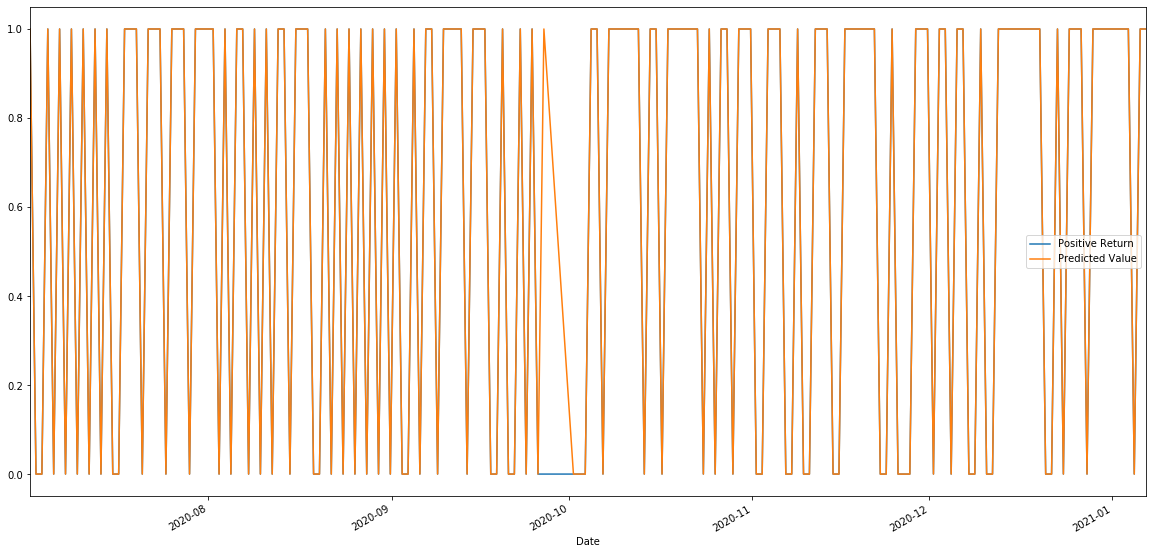

In [260]:
# Plot last 10 records of predicted vs. actual results
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10))
#Results[['Positive Return', 'Predicted Value']].tail(30).plot()

### Replace Predicted Values 0 as -1 (For Shorting)

In [261]:
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Positive Return,Predicted Value
Date,,
2020-07-01 19:00:00,1.0,1.0
2020-07-02 19:00:00,0.0,-1.0
2020-07-03 19:00:00,0.0,-1.0
2020-07-04 19:00:00,1.0,1.0
2020-07-05 19:00:00,0.0,-1.0
...,...,...
2021-01-02 18:00:00,1.0,1.0
2021-01-03 18:00:00,1.0,1.0
2021-01-04 18:00:00,0.0,-1.0


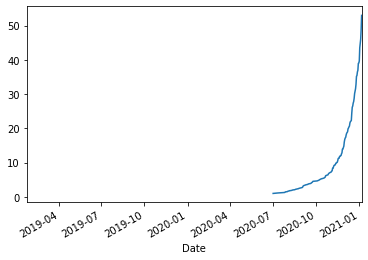

In [262]:
# Calculate cumulative return of model and plot the result
(1 + (trading_signals_df['daily_return'] * Results['Predicted Value'])).cumprod().plot()

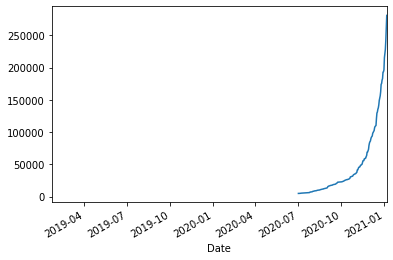

In [133]:
# Set initial capital allocation
initial_capital = 5000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (trading_signals_df['daily_return'] * Results['Predicted Value'])).cumprod()
cumulative_return_capital.plot()

In [263]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

## Feature Importance

In [264]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_

In [265]:
# We can sort the features by their importance
sorted(zip(model.feature_importances_, X_test.columns), reverse=True)

[(0.803292325501058, 'daily_return'),
 (0.10200094555853535, 'vol_change'),
 (0.03753013939083723, 'rsi'),
 (0.02123551178177598, 'macd'),
 (0.015967203688525968, 'ewma_x'),
 (0.013167625182120755, 'psar'),
 (0.006806248897146678, 'bollinger')]

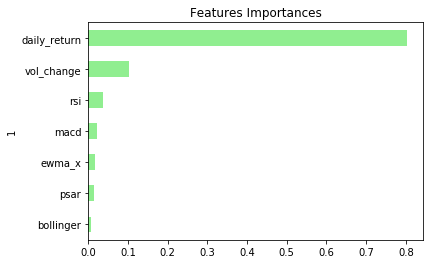

In [266]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X_test.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [267]:
X_new_day = X_test.copy()
y_new_day = y_test.to_frame()
#y_new_day.tail()

In [268]:
X_new_day.loc[date.today()] = [1,1.0,-1,-1,1,0.026,-0.38]
y_new_day.loc[date.today()] = [1]
y_new_day.tail()

,Positive Return
Date,
2021-01-03 18:00:00,1.0
2021-01-04 18:00:00,0.0
2021-01-05 18:00:00,1.0
2021-01-06 18:00:00,1.0
2021-01-10,1.0


In [269]:
# Creating StandardScaler instance
#scaler = StandardScaler()

# Fitting Standard Scaller
#X_scaler = scaler.fit(X_train)

# Scaling data
#X_train_scaled = X_scaler.transform(X_train)
X_new_day_scaled = X_scaler.transform(X_new_day)

In [270]:
#model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
#model.fit(X_train_scaled, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_new_day_scaled)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_new_day.copy()                             #Column positive return 
Results["Predicted Value"] = predictions                #prediction 
Results

,Positive Return,Predicted Value
Date,,
2020-07-01 19:00:00,1.0,1.0
2020-07-02 19:00:00,0.0,0.0
2020-07-03 19:00:00,0.0,0.0
2020-07-04 19:00:00,1.0,1.0
2020-07-05 19:00:00,0.0,0.0
...,...,...
2021-01-03 18:00:00,1.0,1.0
2021-01-04 18:00:00,0.0,0.0
2021-01-05 18:00:00,1.0,1.0
